In [30]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# Data - CIFAR10
have 10 classes - labelled 0 to 9

In [31]:
# download the data which is already there in torchvision repo
transform = transforms.Compose([transforms.ToTensor()])
dataPath = f'/home/wd/Documents/work_stuff/ViT_REPLICATION/data/CIFAR10'
dataset = torchvision.datasets.CIFAR10(root=dataPath, train=False, download=True,  
                                        transform=transform)


In [32]:
img, label = dataset[0]

In [33]:
img

tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
         [0.1843, 0.1294, 0.1412,  ..., 0.1333, 0.1333, 0.

In [34]:
img.shape

torch.Size([3, 32, 32])


### img.numpy()  vs  np.array(img)
For example, the tensor is -> img.shape = torch.Size([3, 32, 32])

#### img.numpy() :::: What it does:

Converts the PyTorch Tensor to a NumPy array.

Shares the same memory (zero-copy).

Only works if the tensor is on CPU.

✅ Fast and efficient.
⚠️ Will raise an error if the tensor is on GPU.

img = img.cpu()  # Must be on CPU
img_np = img.numpy()

#### np.array(img) :::: What it does:
What it does:

Uses NumPy to create an array from the tensor.

Copies the data — does not share memory.

Slower and not recommended for tensors.

Works even if the tensor is on GPU (but will be wrong!).

⚠️ Inefficient.
⚠️ May silently produce unexpected results or copy issues.


| Method          | Converts To NumPy | Shares Memory? | Fast? | GPU Compatible?      | Recommended? |
| --------------- | ----------------- | -------------- | ----- | -------------------- | ------------ |
| `img.numpy()`   | ✅                 | ✅ Yes          | ✅ Yes | ❌ No (CPU only)      | ✅ Yes        |
| `np.array(img)` | ✅                 | ❌ No (copy)    | ❌ No  | ⚠️ Can silently fail | ❌ No         |


In [35]:
img.numpy()

array([[[0.61960787, 0.62352943, 0.64705884, ..., 0.5372549 ,
         0.49411765, 0.45490196],
        [0.59607846, 0.5921569 , 0.62352943, ..., 0.53333336,
         0.49019608, 0.46666667],
        [0.5921569 , 0.5921569 , 0.61960787, ..., 0.54509807,
         0.50980395, 0.47058824],
        ...,
        [0.26666668, 0.16470589, 0.12156863, ..., 0.14901961,
         0.05098039, 0.15686275],
        [0.23921569, 0.19215687, 0.13725491, ..., 0.10196079,
         0.11372549, 0.07843138],
        [0.21176471, 0.21960784, 0.1764706 , ..., 0.09411765,
         0.13333334, 0.08235294]],

       [[0.4392157 , 0.43529412, 0.45490196, ..., 0.37254903,
         0.35686275, 0.33333334],
        [0.4392157 , 0.43137255, 0.44705883, ..., 0.37254903,
         0.35686275, 0.34509805],
        [0.43137255, 0.42745098, 0.43529412, ..., 0.38431373,
         0.37254903, 0.34901962],
        ...,
        [0.4862745 , 0.39215687, 0.34509805, ..., 0.38039216,
         0.2509804 , 0.33333334],
        [0.4

In [36]:
np.transpose(img.numpy(), (1, 2, 0)).shape

(32, 32, 3)

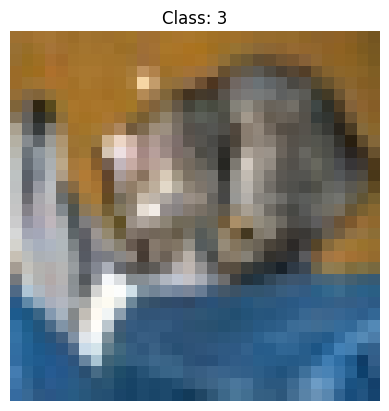

In [37]:
plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) # you need to pass the index : channel, height, width -> height, width, channel
plt.title(f"Class: {label}")
plt.axis('off')
plt.show()

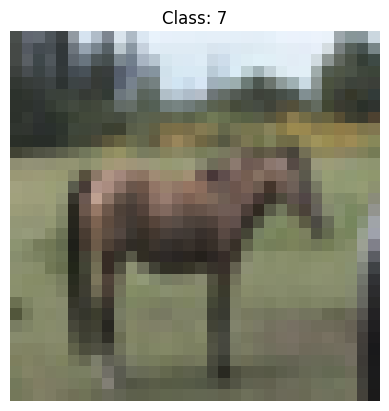

In [38]:
img, label = dataset[9999]
plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) # you need to pass the index : channel, height, width -> height, width, channel
plt.title(f"Class: {label}")
plt.axis('off')
plt.show()

# Patch Embedding
📦 What is the Goal?
We want to:

Break an image into non-overlapping patches (e.g., 4×4).

Flatten each patch.

Project each patch into a vector space (i.e., embedding).

Output shape should be (Batch, Num_Patches, Embedding_Dim) — just like how Transformers expect.


### whats the significance of conv2d here ?

🎯 What are we trying to do?
We want to convert an image (e.g., 32×32) into a sequence of patch vectors, where each patch is represented by a fixed-size vector (like 64-dim, 128-dim etc). This is necessary because:

Transformers expect input as a sequence of vectors: (batch, num_patches, embedding_dim)

So we need some way to go from image pixels → patch vectors.

🧠 This single Conv2d call:

Extracts non-overlapping patches

Flattens each patch internally

Applies a learnable linear transformation to each patch

So it acts like a smart patch extractor + embedder in one step.

🔍 Why Conv2D works perfectly here
kernel_size = patch_size: it looks at one patch at a time.

stride = patch_size: it moves in steps of patch size (no overlap).

out_channels = emb_size: it maps each patch to an emb_size-d vector.

This is exactly what we want:

Divide the image into fixed-size patches, and turn each patch into a vector.

### 🧪 Without Conv2D — what would you do?

If you didn’t use Conv2d, you’d need to:

Slice the image manually into 4×4 patches (nested loops).

Flatten each patch into a vector.

Apply a learnable linear projection (nn.Linear) to each one.

That’s a LOT of code and slow on GPU.

✅ Conv2d gives you all that in one fast, GPU-optimized layer.

🔁 Think of Conv2D here not as a CNN, but as a fast way to do:
Patch → Vector projection for all patches at once.



In [39]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, emb_size=128, img_size=32):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)       # (B, emb_size, H/patch, W/patch)
        print(f'after applying conv2D, {x.shape}')
        x = x.flatten(2)             # (B, emb_size, N)
        print(f'after flattening, {x.shape}')
        x = x.transpose(1, 2)        # (B, N, emb_size)
        print(f'after transpose {x.shape}')
        return x


In [40]:
## UNSQUEEZE : Adds a dimension of size 1 at the specified dim (axis).
img_tensor = img.unsqueeze(0)
img_tensor

tensor([[[[0.2863, 0.3843, 0.3882,  ..., 0.5294, 0.5294, 0.7961],
          [0.2706, 0.3294, 0.2667,  ..., 0.3333, 0.2784, 0.4706],
          [0.2706, 0.3529, 0.2431,  ..., 0.2902, 0.2078, 0.2431],
          ...,
          [0.4824, 0.5176, 0.5059,  ..., 0.4235, 0.2431, 0.1059],
          [0.4510, 0.4824, 0.5059,  ..., 0.4510, 0.2588, 0.1059],
          [0.4549, 0.4745, 0.5059,  ..., 0.4549, 0.2667, 0.1059]],

         [[0.3059, 0.4039, 0.4157,  ..., 0.5882, 0.5843, 0.8431],
          [0.2863, 0.3490, 0.2941,  ..., 0.3725, 0.3216, 0.5216],
          [0.2863, 0.3725, 0.2784,  ..., 0.3176, 0.2431, 0.2902],
          ...,
          [0.5020, 0.5176, 0.5020,  ..., 0.4196, 0.2353, 0.1059],
          [0.4745, 0.4863, 0.4941,  ..., 0.4549, 0.2549, 0.1059],
          [0.4706, 0.4784, 0.5020,  ..., 0.4510, 0.2549, 0.1020]],

         [[0.2941, 0.4431, 0.4471,  ..., 0.5961, 0.6039, 0.8745],
          [0.2745, 0.3804, 0.3176,  ..., 0.3490, 0.3137, 0.5294],
          [0.2745, 0.3922, 0.2902,  ..., 0

In [41]:
img_tensor.shape

torch.Size([1, 3, 32, 32])

In [42]:
patch_size = 4
n_patches = (32 // patch_size) ** 2
projection = nn.Conv2d(3, 128, kernel_size=patch_size, stride=patch_size)


In [43]:
img_tensor

tensor([[[[0.2863, 0.3843, 0.3882,  ..., 0.5294, 0.5294, 0.7961],
          [0.2706, 0.3294, 0.2667,  ..., 0.3333, 0.2784, 0.4706],
          [0.2706, 0.3529, 0.2431,  ..., 0.2902, 0.2078, 0.2431],
          ...,
          [0.4824, 0.5176, 0.5059,  ..., 0.4235, 0.2431, 0.1059],
          [0.4510, 0.4824, 0.5059,  ..., 0.4510, 0.2588, 0.1059],
          [0.4549, 0.4745, 0.5059,  ..., 0.4549, 0.2667, 0.1059]],

         [[0.3059, 0.4039, 0.4157,  ..., 0.5882, 0.5843, 0.8431],
          [0.2863, 0.3490, 0.2941,  ..., 0.3725, 0.3216, 0.5216],
          [0.2863, 0.3725, 0.2784,  ..., 0.3176, 0.2431, 0.2902],
          ...,
          [0.5020, 0.5176, 0.5020,  ..., 0.4196, 0.2353, 0.1059],
          [0.4745, 0.4863, 0.4941,  ..., 0.4549, 0.2549, 0.1059],
          [0.4706, 0.4784, 0.5020,  ..., 0.4510, 0.2549, 0.1020]],

         [[0.2941, 0.4431, 0.4471,  ..., 0.5961, 0.6039, 0.8745],
          [0.2745, 0.3804, 0.3176,  ..., 0.3490, 0.3137, 0.5294],
          [0.2745, 0.3922, 0.2902,  ..., 0

In [44]:
### applying convolution
x = projection(img_tensor)
x

tensor([[[[-0.0202, -0.1045, -0.0300,  ..., -0.0988, -0.3745, -0.1823],
          [-0.0394,  0.0039, -0.0760,  ..., -0.1092, -0.0894, -0.0464],
          [ 0.0695,  0.0468, -0.0259,  ..., -0.0219, -0.0361, -0.1044],
          ...,
          [-0.0519, -0.0913,  0.0129,  ..., -0.1006, -0.1024, -0.1740],
          [-0.0485, -0.1100,  0.0042,  ..., -0.0741, -0.0532, -0.1300],
          [-0.0783, -0.1298, -0.0687,  ..., -0.0541, -0.0476, -0.1475]],

         [[ 0.2131,  0.2673,  0.3952,  ...,  0.3206,  0.2571,  0.3463],
          [ 0.1800,  0.1600,  0.1847,  ...,  0.2684,  0.1805,  0.1569],
          [ 0.1249,  0.1527,  0.1621,  ...,  0.2292,  0.2173,  0.2119],
          ...,
          [ 0.2243,  0.2630,  0.1739,  ...,  0.2378,  0.2373,  0.1576],
          [ 0.2171,  0.1917,  0.1826,  ...,  0.2284,  0.2200,  0.1457],
          [ 0.2292,  0.2096,  0.2355,  ...,  0.2133,  0.2065,  0.1290]],

         [[-0.0165,  0.0415,  0.0923,  ..., -0.0759, -0.1321,  0.1253],
          [ 0.0247, -0.0124, -

In [45]:
x.shape

torch.Size([1, 128, 8, 8])

In [46]:
x.flatten(2).shape

torch.Size([1, 128, 64])

In [47]:
x.flatten(2).transpose(1,2).shape

torch.Size([1, 64, 128])

In [48]:
img_tensor = img.unsqueeze(0)  # Add batch dimension: for one image, the shape will be (1, 3, 32, 32), we are faking the batch size just because the model demands a 4D tensor as the input

patch_embed = PatchEmbedding(patch_size=4, emb_size=128)
with torch.no_grad():
    patch_vectors = patch_embed(img_tensor)

print("Output shape:", patch_vectors.shape)

after applying conv2D, torch.Size([1, 128, 8, 8])
after flattening, torch.Size([1, 128, 64])
after transpose torch.Size([1, 64, 128])
Output shape: torch.Size([1, 64, 128])


# Positional Encoding
### ❓ Why is this needed?
Transformers don’t “see” structure in sequences — they treat them as a bag of vectors. So if we feed in 64 patches, it doesn't know:

Which patch is top-left?

Which one is center?

Which one is bottom-right?

➡️ We solve this by adding positional information to each patch vector.

Transformers don’t know anything about order or position in sequences unless we tell them. Unlike CNNs, which use kernels that scan spatially across pixels, Transformers treat inputs as just a set of tokens.

In ViT:
We give the Transformer a list of 64 patch vectors.
But... it has no clue which patch came from where on the image. 😵

So we need to inject position awareness using positional embeddings.

### ✅ It’s just a tensor added to each patch vector:
patch_embedding:    (1, 64, 128) → 64 patches, each 128-dim
positional_encoding:(1, 64, 128) → 64 positional vectors
positioned = patch_embedding + positional_encoding

So the final input to the Transformer is:
(1, 64, 128) — where each patch vector now includes position info

### 🧠 Two Ways to Do This
Method	Description	Common in
- Fixed Sinusoidal	Uses sine/cosine functions	NLP Transformers (e.g., BERT)
- ✅ Learnable	Positional embeddings are learned during training	ViT, modern vision models

We’ll focus on the learnable version, as used in Vision Transformers.
self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, emb_size)) , num_patches + 1 is to include 'cls_token'.

| Patch Index | Patch Embedding (128D)   | Positional Embedding (128D) | Final Input to Transformer (128D) |
| ----------- | ----------------------- | -------------------------- | -------------------------------- |
| Patch 0     | `[e₀₀, e₀₁, ..., e₀127]` | `[p₀₀, p₀₁, ..., p₀127]`    | `e₀ + p₀`                        |
| Patch 1     | `[e₁₀, e₁₁, ..., e₁127]` | `[p₁₀, p₁₁, ..., p₁127]`    | `e₁ + p₁`                        |
| ...         | ...                     | ...                        | ...                              |
| Patch 63    | ...                     | ...                        | `e₆₃ + p₆₃`                      |


This way:

Even if two patches have identical pixel values (same eᵢ)

Their final representation will be different because of pᵢ

✅ That’s how we encode spatial awareness into a Transformer.


### CLS TOKEN
It’s a special trainable vector that is prepended to the sequence of patch embeddings before feeding into the Transformer.

Originally introduced in BERT (NLP model), it’s reused in ViT.

Transformers process entire sequences, and you typically get one output per token.
But in classification, you want one output for the entire image.

So instead of:

Averaging the patch outputs (like in CNN global pooling),

Or building a separate head,

✅ You just add a [CLS] token, and let the model learn to treat it as a summary collector.

✅ Summary Role of [CLS] Token
Input: Added to start of patch sequence

Transformer: Attends to all patches in every layer

Output: Final hidden state of [CLS] is used for classification

Think of [CLS] as a learnable sponge that absorbs global image information through attention.

🔬 How It Works in Practice

🔢 Suppose:
Patch embedding produces 64 tokens of 128 dims each → shape: (B, 64, 128)

You prepend 1 [CLS] token → now shape: (B, 65, 128)

So:

x.shape after patch embedding = (B, 64, 128)

Add [CLS]: becomes (B, 65, 128)

pos_embedding.shape: (1, 65, 128)


In [49]:
## Output from the previous step - Patch Embedding 
patch_vectors.shape

torch.Size([1, 64, 128])

In [50]:
patch_vectors

tensor([[[ 0.0281,  0.0488, -0.1671,  ...,  0.1449,  0.1038, -0.2975],
         [ 0.0119,  0.0947,  0.0313,  ...,  0.1755, -0.0231, -0.4171],
         [-0.0735,  0.2013, -0.1353,  ...,  0.2423, -0.0250, -0.5145],
         ...,
         [ 0.0921,  0.0644, -0.3029,  ...,  0.1410,  0.0883, -0.3464],
         [ 0.0856,  0.0758, -0.3246,  ...,  0.1737,  0.0869, -0.3674],
         [ 0.0298, -0.0794, -0.3328,  ..., -0.0320,  0.2554, -0.1896]]])

In [ ]:
class ViTInput(nn.Module):
    
    def __init__(self, num_patches=64, emb_size=64, include_cls=True):    
        super().__init__()
        self.include_cls = include_cls
        if include_cls:
            # Create a trainable CLS token
            self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))  # (1, 1, 64)
        else:
            self.cls_token = None
        
        # Positional embedding for all tokens (patches + CLS if present)
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + int(include_cls), emb_size)
        )

    def forward(self, x):  # x shape: (B, 64, 64)        
        B, N, E = x.shape
        
        if self.include_cls:
            cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, E)
            x = torch.cat([cls_tokens, x], dim=1)          # (B, 65, E)

        x = x + self.pos_embedding[:, :x.size(1), :]       # Add positional encoding
        return x


In [52]:
cls_token = nn.Parameter(torch.randn(1, 1, 128))
cls_token

Parameter containing:
tensor([[[ 0.5443, -1.2087, -0.8276,  0.5431,  0.6837,  0.6449, -0.3903,
           1.6828,  1.4183,  1.3319,  2.6950, -0.9619,  1.3587, -0.2581,
          -0.2381, -0.1279,  0.8174, -0.0683, -0.3495, -0.3837, -1.0224,
           1.7470, -1.3680,  1.4968,  1.0419,  1.8361,  1.3865,  0.3257,
          -0.3368,  1.5277, -1.4472,  0.6737,  1.1420, -0.2218, -1.5787,
           0.3148, -0.5148, -0.8375, -0.6938,  0.5123, -0.1617, -0.6039,
          -0.1356, -0.5148, -0.1932, -1.5606,  0.8449, -2.3375, -1.3724,
           0.2222,  0.7883,  1.3188, -0.3839, -1.1409,  0.6007,  1.1602,
          -0.9717, -0.2907,  0.0898,  0.1581,  0.4025,  0.4153, -0.5192,
           0.6851,  2.1454, -0.1097, -1.2872,  1.1641, -0.7736,  1.2010,
           0.4821, -2.3750,  0.5498, -1.0623,  0.7939, -0.9616,  0.7300,
           0.0193,  0.1770,  0.6844, -1.2934, -0.5852, -0.7679,  0.4909,
          -0.2089,  0.0039,  0.2492,  0.4179, -0.8954, -1.0040,  1.3773,
           0.4326,  0.3358,  

In [57]:
patch_vectors.shape

torch.Size([1, 64, 128])

In [72]:
cls_token.shape

torch.Size([1, 1, 128])

In [82]:
num_patches = 64
include_cls = True
emb_size=128

B, N, E = patch_vectors.shape
cls_token = nn.Parameter(torch.randn(1, 1, 128))
cls_tokens = cls_token.expand(B, -1, -1)
patch_vectors_cls_added = torch.cat([cls_tokens, patch_vectors], dim=1)
patch_vectors_cls_added.shape

torch.Size([1, 65, 128])

In [83]:
patch_vectors_cls_added

tensor([[[-0.6458,  1.0369, -1.0193,  ...,  1.7842, -0.1007,  0.2384],
         [ 0.0281,  0.0488, -0.1671,  ...,  0.1449,  0.1038, -0.2975],
         [ 0.0119,  0.0947,  0.0313,  ...,  0.1755, -0.0231, -0.4171],
         ...,
         [ 0.0921,  0.0644, -0.3029,  ...,  0.1410,  0.0883, -0.3464],
         [ 0.0856,  0.0758, -0.3246,  ...,  0.1737,  0.0869, -0.3674],
         [ 0.0298, -0.0794, -0.3328,  ..., -0.0320,  0.2554, -0.1896]]],
       grad_fn=<CatBackward0>)

In [ ]:
pos_embedding = nn.Parameter(
        torch.randn(1, num_patches + int(include_cls), emb_size)
    )
pos_embedding

Parameter containing:
tensor([[[-0.3151, -1.0432, -0.0393,  ..., -0.0140, -1.2721, -1.7620],
         [ 1.3543, -0.7176, -1.4389,  ...,  0.2655, -1.0941,  1.2384],
         [ 2.3830, -1.8270,  0.2797,  ..., -0.5667,  0.1631, -0.5172],
         ...,
         [-0.0358,  1.3445, -0.1702,  ..., -0.8810,  0.1896, -1.4092],
         [ 0.8369, -0.0627, -0.4133,  ..., -1.0886,  1.2613, -0.3744],
         [-0.1815, -0.4302,  2.4264,  ...,  1.7539,  1.8274,  1.6226]]],
       requires_grad=True)

In [85]:
pos_embedding.shape

torch.Size([1, 65, 128])

In [ ]:
pos_embedding[:, ]

Parameter containing:
tensor([[[-0.3151, -1.0432, -0.0393,  ..., -0.0140, -1.2721, -1.7620],
         [ 1.3543, -0.7176, -1.4389,  ...,  0.2655, -1.0941,  1.2384],
         [ 2.3830, -1.8270,  0.2797,  ..., -0.5667,  0.1631, -0.5172],
         ...,
         [-0.0358,  1.3445, -0.1702,  ..., -0.8810,  0.1896, -1.4092],
         [ 0.8369, -0.0627, -0.4133,  ..., -1.0886,  1.2613, -0.3744],
         [-0.1815, -0.4302,  2.4264,  ...,  1.7539,  1.8274,  1.6226]]],
       requires_grad=True)

In [92]:
patch_vectors_cls_added.size(2)

128

In [93]:
pos_embedding = nn.Parameter(
    torch.randn(1, num_patches + int(include_cls), emb_size)
    )
tokens_with_cls = patch_vectors_cls_added + pos_embedding[:, :patch_vectors_cls_added.size(1), :]

In [94]:
tokens_with_cls

tensor([[[-0.6886,  0.0145, -1.1406,  ...,  0.9967, -0.1300,  0.2415],
         [ 3.2012,  0.8436, -0.5777,  ..., -0.4499,  1.4338,  1.1878],
         [ 0.7825, -0.2857,  0.4328,  ...,  0.9572,  1.8117, -1.2131],
         ...,
         [ 0.4234, -1.3387,  1.3495,  ...,  1.0028,  1.1487, -2.0295],
         [-0.2278, -0.4514,  0.0765,  ...,  1.4625,  1.1042, -1.1956],
         [ 0.9122,  0.0558, -1.8295,  ...,  1.7379, -0.2798,  0.5286]]],
       grad_fn=<AddBackward0>)

In [99]:
vit_input = ViTInput(num_patches=64, emb_size=128, include_cls=True)
tokens_with_cls = vit_input(patch_vectors)
print("Final shape with CLS:", tokens_with_cls.shape)  # (1, 65, 64)

Final shape with CLS: torch.Size([1, 65, 128])


# Transformer Encoder Block
💡 Each Transformer block contains:
Multi-Head Self-Attention (MHSA)

Add & LayerNorm

Feedforward MLP

Add & LayerNorm

There are multiple such blocks like 6 or 12.

In [102]:
tokens_with_cls.shape

torch.Size([1, 65, 128])

In [ ]:
import torch
import torch.nn as nn

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=64, num_heads=4, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(embed_dim=emb_size, num_heads=num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(emb_size)
        
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, int(emb_size * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(emb_size * mlp_ratio), emb_size),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # Multi-head Self-Attention with Residual
        x = x + self.attn(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        # Feedforward MLP with Residual
        x = x + self.mlp(self.ln2(x))
        return x

In [110]:
encoder_block = TransformerEncoderBlock(emb_size=128, num_heads=4)
# Pass input tokens through Transformer Encoder Block
with torch.no_grad():  # Disable gradients for now (inference/debug)
    output_tokens = encoder_block(tokens_with_cls)

print("Output shape from Transformer Encoder Block:", output_tokens.shape)


Output shape from Transformer Encoder Block: torch.Size([1, 65, 128])


In [114]:
output_tokens.shape

torch.Size([1, 65, 128])

In [ ]:
output_tokens


tensor([[[ 0.3190, -3.1615,  0.4054,  ...,  1.9170, -2.6788, -0.7548],
         [-0.8424,  0.2914, -1.7966,  ...,  1.3436, -0.3509,  0.9910],
         [ 0.5700, -0.3865, -0.0163,  ...,  0.1557, -2.4257, -0.8484],
         ...,
         [ 2.4268, -0.2838,  0.4983,  ...,  1.5367, -0.2998,  1.0226],
         [-1.2276,  2.2232,  0.0259,  ..., -0.9833, -0.1569, -0.0787],
         [-0.4944, -1.6785,  0.2877,  ...,  0.5237, -1.2672,  0.2341]]])

# Extracting CLS Token for classification

In [116]:
class ClassificationHead(nn.Module):
    def __init__(self, emb_size=64, num_classes=10):
        super().__init__()
        self.norm = nn.LayerNorm(emb_size)
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        cls_token = x[:, 0]       # Extract only the [CLS] token: shape (B, E)
        cls_token = self.norm(cls_token)
        return self.fc(cls_token)  # Final shape: (B, num_classes)


In [118]:
head = ClassificationHead(emb_size=128, num_classes=10)
with torch.no_grad():
    logits = head(output_tokens)

print("Logits shape:", logits.shape)

Logits shape: torch.Size([1, 10])


In [119]:
logits

tensor([[ 0.5009, -0.0218,  0.1075,  0.9305, -0.6950, -0.1372,  0.2581, -0.5056,
          0.2392,  0.5679]])

# Complete Class Testing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# config numbers
class ViTConfig:
    def __init__(self,
                 img_size=32,
                 patch_size=4,
                 in_channels=3,
                 emb_size=64,
                 depth=6,
                 num_heads=4,
                 mlp_ratio=4.0,
                 num_classes=10,
                 dropout=0.1):
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.emb_size = emb_size
        self.depth = depth
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio
        self.num_classes = num_classes
        self.dropout = dropout

# Patch Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, emb_size, img_size):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)        # (B, emb_size, H/patch, W/patch)
        x = x.flatten(2)              # (B, emb_size, N)
        x = x.transpose(1, 2)         # (B, N, emb_size)
        return x                      # Shape: (B, N, E)

# Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size, num_heads, mlp_ratio, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(embed_dim=emb_size, num_heads=num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, int(emb_size * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(emb_size * mlp_ratio), emb_size),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        x = x + self.mlp(self.ln2(x))
        return x

# Vit Test Model
class VisionTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        cfg = config["model"]
        
        self.CHANNEL = cfg["in_channels"]
        self.PATCH = cfg["patch_size"]
        self.EMBEDDING = cfg["emb_size"]
        self.IMAGE = cfg["img_size"]
        self.NUM_HEADS = cfg["num_heads"]
        self.MLP_RATIO = cfg["mlp_ratio"]
        self.DROPOUT = cfg["dropout"]
        self.NUM_CLASS = cfg["num_classes"]
        self.DEPTH = cfg["depth"]

        self.patch_embed = PatchEmbedding(
            in_channels=self.CHANNEL,
            patch_size=self.PATCH,
            emb_size=self.EMBEDDING,
            img_size=self.IMAGE
        )

        self.n_patches = (self.IMAGE// self.PATCH) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.EMBEDDING))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.n_patches + 1, self.EMBEDDING))

        self.encoder = nn.Sequential(*[
            TransformerEncoderBlock(
                emb_size=self.EMBEDDING,
                num_heads=self.NUM_HEADS,
                mlp_ratio=self.MLP_RATIO,
                dropout=self.DROPOUT
            ) for _ in range(self.DEPTH)
        ])

        self.norm = nn.LayerNorm(self.EMBEDDING)
        self.head = nn.Linear(self.EMBEDDING, self.NUM_CLASS)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.encoder(x)
        cls_out = self.norm(x[:, 0])
        return self.head(cls_out)


In [2]:
import sys
import os
CURR_PATH = f'/home/wd/Documents/work_stuff/ViT_REPLICATION'
sys.path.append(os.path.abspath(CURR_PATH))  # Adds root directory to sys.path

In [3]:
from utils.config_loader import load_config

In [4]:
# loading config file for CIFAR10
config = load_config(f"{CURR_PATH}/config/vit_test_config.yaml")
config

{'root': {'path': '/home/wd/Documents/work_stuff/ViT_REPLICATION'},
 'data': {'dataset': 'CIFAR10',
  'data_path': '/home/wd/Documents/work_stuff/ViT_REPLICATION/data/CIFAR10',
  'batch_size': 64,
  'num_workers': 4,
  'img_size': 32},
 'model': {'img_size': 32,
  'patch_size': 4,
  'in_channels': 3,
  'emb_size': 128,
  'depth': 4,
  'num_heads': 4,
  'mlp_ratio': 4.0,
  'num_classes': 10,
  'dropout': 0.1}}

### building the model

In [138]:
model = VisionTransformer(config)

dummy_input = torch.randn(1, 3, 32, 32)
print(dummy_input.shape)
with torch.no_grad():
    output = model(dummy_input)

print("Output shape:", output.shape)  # torch.Size([1, 10])


torch.Size([1, 3, 32, 32])
Output shape: torch.Size([1, 10])


In [136]:
output

tensor([[ 0.3500,  0.0149,  0.6415,  0.1470,  0.7542, -0.4720, -0.0573, -0.1689,
         -1.3927,  0.0716]])

### loading Data CIFAR10

In [5]:
from utils.data_loader import DatasetLoader

# loading config file for CIFAR10
data_cfg = config["data"]
DATASET = data_cfg["dataset"]
DATA_DIR = data_cfg["data_path"]
BATCH = data_cfg["batch_size"]
NUM_WORKERS = data_cfg["num_workers"]
IMAGE = data_cfg["img_size"]

# loading data
loader = DatasetLoader(dataset_name=DATASET,
                        data_dir=DATA_DIR,
                        batch_size=BATCH,
                        num_workers=NUM_WORKERS,
                        img_size=IMAGE)
train_loader, test_loader = loader.get_loaders()
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")


Train batches: 782, Test batches: 157


In [6]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break


torch.Size([64, 3, 32, 32]) torch.Size([64])


In [7]:
print('classes present in the batch of 64 images')
labels

classes present in the batch of 64 images


tensor([4, 2, 9, 6, 7, 5, 2, 0, 2, 4, 8, 2, 5, 7, 0, 2, 4, 5, 1, 7, 6, 8, 0, 5,
        2, 5, 0, 8, 8, 1, 5, 7, 0, 5, 5, 2, 5, 7, 0, 3, 5, 2, 8, 0, 8, 5, 1, 4,
        3, 5, 8, 7, 3, 1, 6, 2, 1, 8, 6, 2, 5, 8, 4, 4])